In [1]:
import os
import numpy as np
import tensorflow as tf
import json
from tensorflow.keras.models import model_from_json
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle
from tqdm.auto import tqdm
from utils import *
import cv2
import plotly.graph_objects as go
from scipy.signal import butter, sosfilt

In [2]:
def unet(pretrained_weights = None,input_size = (None,None,None,1)):
    inputs = layers.Input(input_size)
    conv1 = layers.Conv3D(16, (3,3,3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv3D(16, (3,3,3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling3D(pool_size=(2,2,2))(conv1)

    conv2 = layers.Conv3D(32, (3,3,3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv3D(32, (3,3,3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling3D(pool_size=(2,2,2))(conv2)

    conv3 = layers.Conv3D(64, (3,3,3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv3D(64, (3,3,3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling3D(pool_size=(2,2,2))(conv3)

    conv4 = layers.Conv3D(512, (3,3,3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv3D(512, (3,3,3), activation='relu', padding='same')(conv4)

    up5 = layers.Concatenate(axis=-1)([layers.UpSampling3D(size=(2,2,2))(conv4), conv3])
    conv5 = layers.Conv3D(64, (3,3,3), activation='relu', padding='same')(up5)
    conv5 = layers.Conv3D(64, (3,3,3), activation='relu', padding='same')(conv5)

    up6 = layers.Concatenate(axis=-1)([layers.UpSampling3D(size=(2,2,2))(conv5), conv2])
    conv6 = layers.Conv3D(32, (3,3,3), activation='relu', padding='same')(up6)
    conv6 = layers.Conv3D(32, (3,3,3), activation='relu', padding='same')(conv6)

    up7 = layers.Concatenate(axis=-1)([layers.UpSampling3D(size=(2,2,2))(conv6), conv1])
    conv7 = layers.Conv3D(16, (3,3,3), activation='relu', padding='same')(up7)
    conv7 = layers.Conv3D(16, (3,3,3), activation='relu', padding='same')(conv7)

    conv8 = layers.Conv3D(1, (1,1,1), activation='sigmoid')(conv7)

    model = tf.keras.Model(inputs=[inputs], outputs=[conv8])
    return model

In [3]:
def inference(model, input, threshold = 0.7, raw = False) -> np.ndarray:
    # Define the target output shape
    output_shape = (300, 300, 1259)
    model_shape = (128,128,128)
    # Create an empty array for the output and a weight map for averaging
    output = np.zeros(output_shape, dtype=np.float32)
    weight_map = np.zeros(output_shape, dtype=np.float32)

    stride = tuple(int(s * 0.9) for s in model_shape)  # (1-0.9)*100% overlap

    # Ensure full coverage by calculating the number of steps in each dimension
    steps_x = range(0, output_shape[0] - model_shape[0] + 1, stride[0])
    steps_y = range(0, output_shape[1] - model_shape[1] + 1, stride[1])
    steps_z = range(0, output_shape[2] - model_shape[2] + 1, stride[2])

    # Add final steps to cover the edges if necessary
    if (output_shape[0] - model_shape[0]) % stride[0] != 0:
        steps_x = list(steps_x) + [output_shape[0] - model_shape[0]]
    if (output_shape[1] - model_shape[1]) % stride[1] != 0:
        steps_y = list(steps_y) + [output_shape[1] - model_shape[1]]
    if (output_shape[2] - model_shape[2]) % stride[2] != 0:
        steps_z = list(steps_z) + [output_shape[2] - model_shape[2]]

    # Iterate through the dataset in patches
    for z in steps_z:
        for y in steps_y:
            for x in steps_x:
                patch = input[x:x + model_shape[0], y:y + model_shape[1], z:z + model_shape[2]]
                patch = patch[np.newaxis, ..., np.newaxis]
                patch_pred = model.predict(patch, verbose=0)  # Add batch dimension
                patch_pred = patch_pred[0, ..., 0].astype(np.float32)
                output[x:x + model_shape[0], y:y + model_shape[1], z:z + model_shape[2]] += patch_pred
                weight_map[x:x + model_shape[0], y:y + model_shape[1], z:z + model_shape[2]] += 1

    weight_map[weight_map == 0] = 1
    if raw:
        output /= weight_map
    else:
        output /= weight_map
        output = (output > threshold).astype(np.uint8)
    return output

In [4]:
def butter_bandpass(seismic, lowcut, highcut):
    order = 4
    fs = 250
    sos = butter(order, [lowcut,highcut], btype='band', fs=fs, output='sos')
    return sosfilt(sos, seismic)

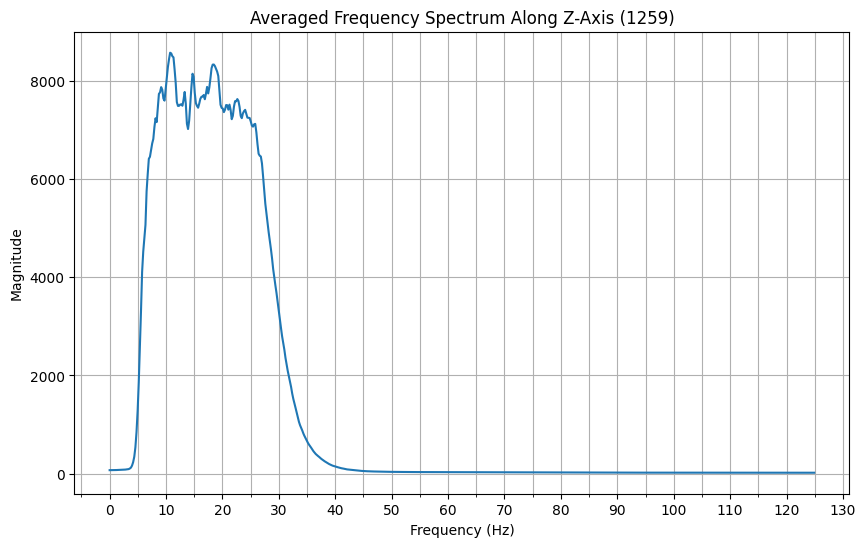

In [5]:
seismic_data = np.load("validation_data/2023-10-05_d8f1c416/seismicCubes_RFC_fullstack_2023.76141493.npy")
fs = 250
# Compute FFT along the 1259 axis (z-axis)
fft_result = np.fft.rfft(seismic_data, axis=2)  # Perform FFT along the last axis (1259)
fft_magnitude = np.abs(fft_result)  # Get the magnitude of the FFT
freqs = np.fft.rfftfreq(seismic_data.shape[2], d=1/fs)  # Compute frequency bins

# Average the FFT magnitude across the 300x300 grid
avg_fft_magnitude = np.mean(fft_magnitude, axis=(0, 1))  # Average across (300, 300)

# Plot the frequency spectrum
plt.figure(figsize=(10, 6))
plt.plot(freqs, avg_fft_magnitude)
plt.title('Averaged Frequency Spectrum Along Z-Axis (1259)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(which='both')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))  # Major grid every 10 Hz
ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))   # Minor grid every 2 Hz
plt.show()

In [ ]:
seismic_data = np.load("validation_data/2023-10-05_d8f1c416/seismicCubes_RFC_fullstack_2023.76141493.npy")
filtered_data = butter_bandpass(seismic_data,5,30)
plt.imshow(seismic_data[220, ...].T, cmap="gray")
plt.show()
plt.imshow(filtered_data[220, ...].T, cmap="gray")
plt.show()

In [5]:
def subsample_points(x, y, z, max_points=100000):
    if len(x) > max_points:
        indices = np.random.choice(len(x), max_points, replace=False)
        x = np.array(x)[indices]
        y = np.array(y)[indices]
        z = np.array(z)[indices]
    return x, y, z

model = unet()
model.load_weights('20250103/083748.h5')
fault = np.load("training_data/2023-10-05_c7dd0d8e/fault_segments_2023.76134075.npy")
seismic_data = np.load("training_data/2023-10-05_c7dd0d8e/seismicCubes_RFC_fullstack_2023.76134075.npy")
seismic_data = butter_bandpass(seismic_data,5,30)
pred = inference(model,seismic_data,0.95)
pred[:, :, :200] = 0
pred[:, :, -20:] = 0

# Calculate false positives and false negatives
false_positive = (pred & ~fault).astype(np.uint8)  # Predicted as fault but not in truth
false_negative = (fault & ~pred).astype(np.uint8)  # True fault but missed in prediction

# Initialize lists to store coordinates for FP and FN
fp_x, fp_y, fp_z = [], [], []
fn_x, fn_y, fn_z = [], [], []

print(f"num_fp: {np.sum(false_positive == 1)}")
print(f"num_fn: {np.sum(false_negative == 1)}")
print(f"dice: {get_dice(pred,fault)}")

# Get indices of false positives for this slice
fp_indices = np.where(false_positive == 1)
fn_indices = np.where(false_negative == 1)

# Append the coordinates to the lists
fp_x.extend(fp_indices[0])  # x-coordinates (width)
fp_y.extend(fp_indices[1])  # y-coordinates (height)
fp_z.extend(fp_indices[2])  # z-coordinates (depth)

fn_x.extend(fn_indices[0])  # x-coordinates (width)
fn_y.extend(fn_indices[1])  # y-coordinates (height)
fn_z.extend(fn_indices[2])  # z-coordinates (depth)

# Subsampling
fp_x, fp_y, fp_z = subsample_points(fp_x, fp_y, fp_z, max_points=100000)
fn_x, fn_y, fn_z = subsample_points(fn_x, fn_y, fn_z, max_points=100000)

# Create a 3D scatter plot to show FP and FN for the entire volume
fig = go.Figure()

# False negative points (True fault but missed in prediction)
fig.add_trace(go.Scatter3d(
    x=fn_x,
    y=fn_y,
    z=fn_z,
    mode='markers',
    marker=dict(size=4, color='yellow', opacity=0.1),
    name='False Negative'
))

# False positive points (Predicted as fault but not in ground truth)
fig.add_trace(go.Scatter3d(
    x=fp_x,
    y=fp_y,
    z=fp_z,
    mode='markers',
    marker=dict(size=4, color='red', opacity=0.1),
    name='False Positive'
))

# Update layout for 3D plot
fig.update_layout(
    title="3D Visualization of False Positives and False Negatives (Full Volume)",
    scene=dict(
        xaxis_title='Width (X)',
        yaxis_title='Height (Y)',
        zaxis_title='Depth (Z)',
        zaxis=dict(
            autorange='reversed',  # Invert the z-axis
        ),
        aspectmode="cube"
    ),
    showlegend=True
)

# Show the plot
fig.show()

num_fp: 641568
num_fn: 417265
dice: 0.6015978483643182


In [ ]:
model = unet()
model.load_weights('combined_more_fault/212846.h5')
base_path = "training_data"
results = {}
for sample_id in tqdm(os.listdir(base_path)):
    sample_path = os.path.join(base_path, sample_id)
    seismic_file = None
    for file in os.listdir(sample_path):
        if file.startswith("seismicCubes_") and file.endswith(".npy"):
            seismic_file = os.path.join(sample_path, file)
        elif file.startswith("fault_") and file.endswith(".npy"):
            fault_file = os.path.join(sample_path, file)

    fault = np.load(fault_file)
    pred = inference(model,np.load(seismic_file),0.95)

    true_positive = int(np.sum(fault * pred))
    false_positives = int(np.sum((1 - fault) * pred))
    false_negatives = int(np.sum(fault * (1 - pred)))
    results[sample_id] = {
            "true_positive": true_positive,
            "false_positive": false_positives,
            "false_negative": false_negatives
        }
with open("train_tp_fp_fn.json", "w") as json_file:
    json.dump(results, json_file, indent=4)

In [2]:
# Load the JSON file
with open("train_tp_fp_fn.json", "r") as json_file:
    results = json.load(json_file)

# Sort by the sum of FP and FN
sorted_results = sorted(
    results.items(),
    key=lambda x: x[1]["true_positive"]/(x[1]["false_positive"] + x[1]["false_negative"]),
    reverse=False  # Sort in descending order (highest FP + FN first)
)

# Print the sorted results
print("Sorted Results (by FP + FN):")
for sample_id, metrics in sorted_results:
    fp = metrics["false_positive"]
    fn = metrics["false_negative"]
    tp = metrics["true_positive"]
    print(f"Sample: {sample_id}, FP: {fp}, FN: {fn}, TP: {tp}, FP+FN: {fp + fn}")

Sorted Results (by FP + FN):
Sample: 2023-10-05_37fd5dd2, FP: 4323, FN: 0, TP: 0, FP+FN: 4323
Sample: 2023-10-05_407bcfc6, FP: 14186, FN: 0, TP: 0, FP+FN: 14186
Sample: 2023-10-05_74a447f1, FP: 1932, FN: 0, TP: 0, FP+FN: 1932
Sample: 2023-10-05_795448d4, FP: 1452, FN: 0, TP: 0, FP+FN: 1452
Sample: 2023-10-05_aa1525c4, FP: 14765, FN: 0, TP: 0, FP+FN: 14765
Sample: 2023-10-05_ba087996, FP: 18883, FN: 0, TP: 0, FP+FN: 18883
Sample: 2023-10-05_c923057a, FP: 37298, FN: 0, TP: 0, FP+FN: 37298
Sample: 2023-10-05_a01e54fa, FP: 33711, FN: 1433, TP: 411, FP+FN: 35144
Sample: 2023-10-05_3e94b9cf, FP: 7723, FN: 587, TP: 967, FP+FN: 8310
Sample: 2023-10-05_9a609f19, FP: 21502, FN: 2215, TP: 3179, FP+FN: 23717
Sample: 2023-10-05_6eebde32, FP: 7407, FN: 1588, TP: 3188, FP+FN: 8995
Sample: 2023-10-05_bf3d1a9a, FP: 9083, FN: 2727, TP: 4695, FP+FN: 11810
Sample: 2023-10-05_6d79e086, FP: 47228, FN: 39220, TP: 40298, FP+FN: 86448
Sample: 2023-10-05_12b08519, FP: 41622, FN: 2478, TP: 24244, FP+FN: 44100
Sa

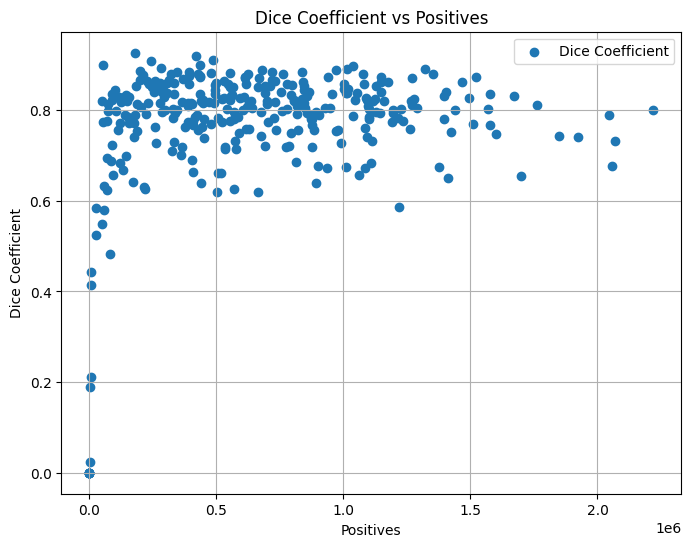

In [3]:
# Load JSON file
with open('train_tp_fp_fn.json', 'r') as f:
    data = json.load(f)

# Extract data from JSON
positive_values = []
dice_values = []

for sample_id, metrics in data.items():
    tp = metrics['true_positive']
    fp = metrics['false_positive']
    fn = metrics['false_negative']
    dice = 2 * tp / (2 * tp + fn + fp) if tp + fn + fp > 0 else 0  # Dice coefficient
    positive_values.append(tp+fn)
    dice_values.append(dice)

# Convert to numpy arrays for easier processing
positive_values = np.array(positive_values)
dice_values = np.array(dice_values)

# Plot the graph
plt.figure(figsize=(8, 6))
plt.scatter((positive_values), dice_values, label="Dice Coefficient")  # Add 1 to avoid log10(0)
plt.xlabel("Positives")
plt.ylabel("Dice Coefficient")
plt.title("Dice Coefficient vs Positives")
plt.grid(True)
plt.legend()
plt.show()